Classical Search for Problem Solving
===

**Dr Chao Shu (chao.shu@qmul.ac.uk)**

In [1]:
# Import required libraries
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import heapq

## Learning Outcomes
---

By the end of this notebook, you should be able to:
- Understand the fundamentals of search problems
- Differentiate between uninformed and informed search strategies
- Implement and analyze basic search algorithms
- Compare the performance characteristics of different algorithms

## Introduction
---

At the end of the L01, you found out that even the SOTA LLMs with billions of parameters, trained on vast amounts of data, struggle to solve the 8-puzzle problem. 

In this lesson, we will explore several basic search algorithms to solve problems without training any models, which can still be generalised to some extent for certain types of problems. The problem-solving agents use search algorithms to navigate through a set of state space of the problem and look for the goal states in order to return solutions, if they exist in the state space. We will deep dive into **uninformed** and **informed** search strategies to find solutions more efficiently.

### What is a Search Problem?

A search problem is a computational task where we need to find a sequence of actions that leads from an initial state to a goal state. In artificial intelligence, search problems form the foundation for many complex tasks such as planning, puzzle solving, and pathfinding.

Search problems are characterized by the following:
1. **A set of possible states** the system can be in
2. **A set of actions** that can transition the system between states
3. **An initial state** where the search begins
4. **A goal test** to determine when we've reached a solution
5. **A path cost function** to evaluate different solutions

The goal of a search algorithm is to find a sequence of actions that transforms the initial state into a goal state, ideally minimising some cost measure.

One application of the search algorithm is to find the shortest route between two cities.

The route finding problem can be formulated as follows:

- **Initial state**: denoted by $s_0$, is any state that can be designated as the starting point.
- **Actions**: $Action(s)$, denoted by: $\{a_1, a_2, a_3, ...\}$, is a set of the possible actions available to the agent at any given state.
- **Results**: $Result(s, a)$, denoted by $s'$, is the new stage where the agent ends up after taking an action at a given state.
- **Goal Test**, $GoalTest(s)$, denoted by a boolean of `True` or `False`, checks whether the current state is the goal state.
- **Path Cost** is the sum of the cost of the individual steps. In the route finding problem, the cost could be the distance between two cities. A **path** in the state space is a sequence of states connected by a sequence of actions.
- **Step Cost** The step cost of taking action $a$ in state $s$ to reach state $s'$ is denoted by $c(s,a,s')$

Together, the initial state, actions, and transition model implicitly define the state space of the problem—the set of all states reachable from the initial state by any sequence of actions. The state space forms a directed network or graph in which the nodes are states and the links between nodes are actions.

A **solution** to a problem is an action sequence that leads from the initial state to a goal state. Solution quality is measured by the path cost function, and an **optimal solution** has the lowest path cost among all solutions.

**Example Problems**

**1. Romania Map Problem**

This is a classic path-finding problem where we need to find a route between cities in Romania. The state space consists of cities, actions are movements along roads connecting cities, and the goal is to reach a specific destination city (usually Bucharest). The path cost is typically the total distance traveled.

**2. 8-Puzzle (Sliding Puzzle) Problem**

The 8-puzzle consists of a 3×3 grid with 8 numbered tiles and one empty space. A tile adjacent to the empty space can slide into that space. The goal is to achieve a specific configuration (usually with the tiles in numerical order).
- State space: All possible arrangements of the tiles
- Actions: Moving tiles into the empty space
- Goal test: Checking if the current arrangement matches the goal configuration
- Path cost: Usually the number of moves made

### Measuring problem-solving performance

- Completeness: Is the algorithm guaranteed to find a solution when there is one?
- Optimality: Does the strategy find the optimal solution, as defined on page 68?
- Time complexity: How long does it take to find a solution?
- Space complexity: How much memory is needed to perform the search?

### Why Learn Classical Search

As you can find from the example of solving 8-puzzle problem at the end of the last lesson, even the SOTA reasoning LLMs nowadays are struggling to solve the problem. Bear in mind that those LLMs are trained with a vast amount of data for several months at least.

While deep learning approaches have gained prominence in mondern AI domains, classical search algorithms continue to provide reliable, explainable, and optimal solutions for well-defined problems using small amount of resources.

> One thing that should be learned from the bitter lesson is the great power of general purpose methods, of methods that continue to scale with increased computation even as the available computation becomes very great. The two methods that seem to scale arbitrarily in this way are **search and learning**.
> 
> --- Richard S. Sutton

![Rich Sutton](./imgs/L02_RichSutton_TuringAward.jpg)

Image Source: https://youtu.be/9_PepvnqIfU

### Uninformed and Informed Search 

**Uninformed search** strategies have no additional information about states beyond that provided in the problem definition, so they can only proceed by generating successors until they find a goal state. 

**Informed search** strategies can prioritise “more promising” states, also called heuristic search strategies.

![Search Categories](./imgs/L02_Search_Categories.svg)

### Route Finding Problems

In the folowing sections, we'll use the Romania Map problem as an example to demonstrate how the different search algorithms work.

**Definitions**

The State Space is the entire area. At every point of searching, we want to separate the state out into three parts.
- Frontier: The set of all leaf nodes available for expansion at any given
point is called the frontier.
- Explored: The explored part of the state except the frontier.
- Unexplored.

Actions are specific to each city.

<img src="./imgs/L02_RomaniaMap.png" alt="A simplified road map of part of Romania" style="width:80%; height:auto;">

Image Source: Figure 3.2 AIMA 3rd Ed.

#### 🧑‍🏫 Demo Environment Preparation

Define the function to create romania map.

In [2]:
def create_romania_graph():
    """Create the Romania map graph from AIMA with manual layout"""
    G = nx.Graph()
    
    # Cities and connections from AIMA Romania map
    cities = [
        ('Arad', 'Zerind', 75),
        ('Arad', 'Sibiu', 140),
        ('Arad', 'Timisoara', 118),
        ('Zerind', 'Oradea', 71),
        ('Oradea', 'Sibiu', 151),
        ('Timisoara', 'Lugoj', 111),
        ('Lugoj', 'Mehadia', 70),
        ('Mehadia', 'Drobeta', 75),
        ('Drobeta', 'Craiova', 120),
        ('Sibiu', 'Fagaras', 99),
        ('Sibiu', 'Rimnicu Vilcea', 80),
        ('Rimnicu Vilcea', 'Craiova', 146),
        ('Rimnicu Vilcea', 'Pitesti', 97),
        ('Craiova', 'Pitesti', 138),
        ('Fagaras', 'Bucharest', 211),
        ('Pitesti', 'Bucharest', 101),
        ('Bucharest', 'Giurgiu', 90),
        ('Bucharest', 'Urziceni', 85),
        ('Urziceni', 'Hirsova', 98),
        ('Hirsova', 'Eforie', 86),
        ('Urziceni', 'Vaslui', 142),
        ('Vaslui', 'Iasi', 92),
        ('Iasi', 'Neamt', 87)
    ]
    
    for edge in cities:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    # Manual positions matching AIMA book layout
    pos = {
        'Arad': (0, 0),
        'Zerind': (-1, 2),
        'Oradea': (1, 4),
        'Timisoara': (-3, -2),
        'Lugoj': (-1, -4),
        'Mehadia': (1, -6),
        'Drobeta': (3, -8),
        'Craiova': (6, -6),
        'Sibiu': (4, 0),
        'Fagaras': (8, 2),
        'Rimnicu Vilcea': (6, -2),
        'Pitesti': (8, -4),
        'Bucharest': (12, 0),
        'Giurgiu': (12, -2),
        'Urziceni': (14, 2),
        'Hirsova': (16, 4),
        'Eforie': (18, 6),
        'Vaslui': (16, 0),
        'Iasi': (14, -2),
        'Neamt': (12, -4)
    }

    return G, 'Arad', 'Bucharest', pos

Define the function to visualise the frontier/explored nodes and found path.

In [3]:
def visualize_graph(graph, pos, start, end, explored, frontier, path=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.clear()
    
    # Adjust figure margins for better spacing
    plt.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.9)
    
    # Node colors
    node_colors = []
    for node in graph.nodes():
        if node in explored:
            color = 'grey'
        elif node in frontier:
            color = 'orange'
        else:
            color = 'skyblue'
        node_colors.append(color)
    
    # Draw normal edges first
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='black', ax=ax, width=1.5)
    
    # Draw edge labels (weights) if they exist
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    if edge_labels:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    
    # Draw nodes with increased size
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, ax=ax, node_size=800)
    
    # Draw special node borders for start and end nodes
    start_node = nx.draw_networkx_nodes(graph, pos, nodelist=[start], 
                                      node_color='none', 
                                      node_size=800,
                                      edgecolors='red', 
                                      linewidths=2)
    end_node = nx.draw_networkx_nodes(graph, pos, nodelist=[end], 
                                    node_color='none', 
                                    node_size=800,
                                    edgecolors='green', 
                                    linewidths=2)
    
    # Draw node labels with adjusted font size
    nx.draw_networkx_labels(graph, pos, ax=ax, font_size=9)
    
    # Highlight path
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='blue', width=2, ax=ax)
    
    # Display lists BELOW THE GRAPH with number of explored nodes
    explored_text = f"Explored ({len(explored)}): {explored}"
    frontier_text = f"Frontier: {frontier}"
    text_content = f"{explored_text}\n{frontier_text}"
    
    fig = ax.figure
    
    # Remove previous text if it exists
    if hasattr(fig, 'info_text'):
        fig.info_text.remove()
    
    # Add new text and store a reference to it
    fig.info_text = fig.text(
        0.5, 0.05,
        text_content,
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray')
    )
    
    plt.draw()

def visualize_astar(graph, pos, start, end, explored, frontier_with_scores, path=None, ax=None):
    """
    Special visualization function for A* search with f_scores.
    
    Args:
        graph: NetworkX graph object
        pos: Dictionary of node positions
        start: Start node
        end: Goal node
        explored: List of explored nodes
        frontier_with_scores: List of tuples (node, f_score)
        path: Found path (if any)
        ax: Matplotlib axis
    """
    if ax is None:
        ax = plt.gca()
    ax.clear()
    
    # Adjust figure margins for better spacing
    plt.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.9)
    
    # Extract just the nodes without scores for coloring
    frontier_nodes = [node for node, _ in frontier_with_scores]
    
    # Node colors
    node_colors = []
    for node in graph.nodes():
        if node in explored:
            color = 'grey'
        elif node in frontier_nodes:
            color = 'orange'
        else:
            color = 'skyblue'
        node_colors.append(color)
    
    # Draw normal edges first
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), edge_color='black', ax=ax, width=1.5)
    
    # Draw edge labels (weights) if they exist
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    if edge_labels:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    
    # Draw nodes with increased size
    nx.draw_networkx_nodes(graph, pos, node_color=node_colors, ax=ax, node_size=800)
    
    # Draw special node borders for start and end nodes
    start_node = nx.draw_networkx_nodes(graph, pos, nodelist=[start], 
                                      node_color='none', 
                                      node_size=800,
                                      edgecolors='red', 
                                      linewidths=2)
    end_node = nx.draw_networkx_nodes(graph, pos, nodelist=[end], 
                                    node_color='none', 
                                    node_size=800,
                                    edgecolors='green', 
                                    linewidths=2)
    
    # Draw node labels with adjusted font size
    nx.draw_networkx_labels(graph, pos, ax=ax, font_size=9)
    
    # Draw f_scores for frontier nodes
    f_score_labels = {}
    for node, score in frontier_with_scores:
        # Format the score to 1 decimal place if it's a float
        formatted_score = f"{score:.1f}" if isinstance(score, float) else f"{score}"
        f_score_labels[node] = formatted_score
        
    # Position the f_score labels slightly offset from nodes (ABOVE nodes, not below)
    f_score_pos = {node: (pos[node][0], pos[node][1] + 1.2) for node in f_score_labels}
    nx.draw_networkx_labels(graph, f_score_pos, labels=f_score_labels, 
                           font_size=8, font_color='blue', 
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='blue'))
    
    # Highlight path
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='blue', width=2, ax=ax)
    
    # Display lists BELOW THE GRAPH with number of explored nodes
    explored_text = f"Explored ({len(explored)}): {explored}"
    frontier_pairs = [f"{node}({score:.1f})" for node, score in frontier_with_scores]
    frontier_text = f"Frontier: {frontier_pairs}"
    text_content = f"{explored_text}\n{frontier_text}"
    
    fig = ax.figure
    
    # Remove previous text if it exists
    if hasattr(fig, 'info_text'):
        fig.info_text.remove()
    
    # Add new text and store a reference to it
    fig.info_text = fig.text(
        0.5, 0.05,
        text_content,
        horizontalalignment='center',
        verticalalignment='bottom',
        fontsize=8,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray')
    )
    
    plt.draw()

Set the problem and preview the initial state.

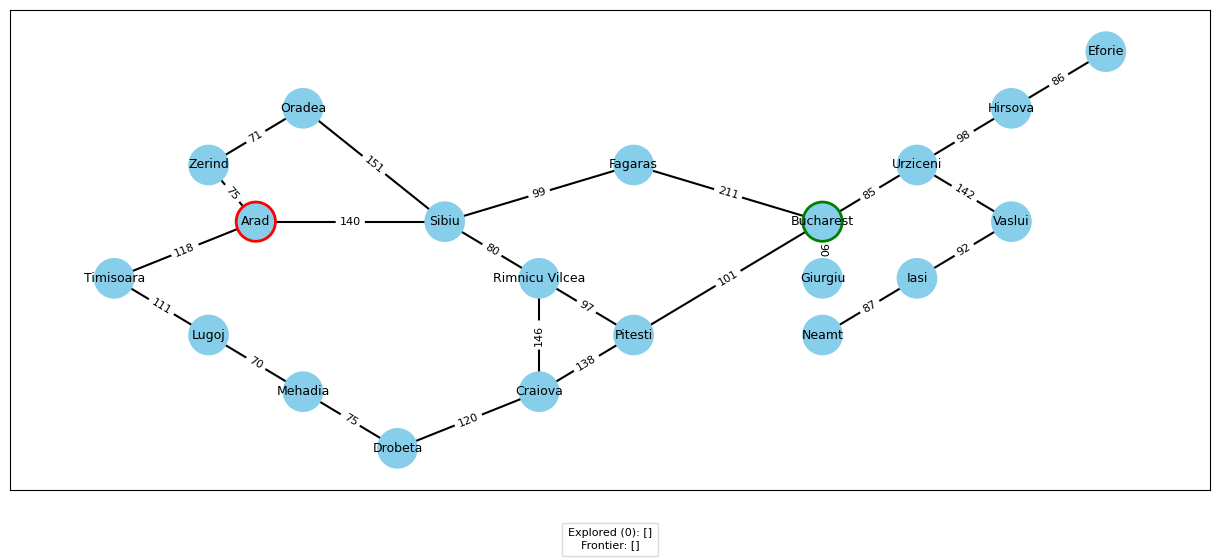

In [4]:
# Set start and end
start = 'Arad'
end = 'Bucharest'

graph, default_start, default_end, pos = create_romania_graph()

# Validate input cities
valid_cities = set(graph.nodes)
start = start if start in valid_cities else default_start
end = end if end in valid_cities else default_end

# Create a wider but shorter figure
fig, ax = plt.subplots(figsize=(15, 6))
visualize_graph(graph, pos, start, end, [], [], None, ax=ax)

## Uninformed Search
---

Breadth-First Search (BFS) is one of the simplest and most intuitive search algorithms. It systematically explores the search space by expanding the shallowest unexplored nodes first.

The most common types of uninformed search are listed as follows:

- **Breadth-first Search (BFS)** is a search strategy that expands the shallowest unexpanded node first. BFS expands the root node, then explores all the children of the root node, and so on.
- **Depth-first Search (DFS)** applies a similar search strategy as BFS but expands the deepest node in the current frontier of the search tree. DFS expands the first child of the root node and explores farther to the deepest leaf node.
- **Uniform Cost Search (UCS)** is a search strategy that expands the successor node with the cheapest cost. In a route finding problem, the cheapest cost could be defined as the shortest distance (in miles) between two cities.

Note: For BFS and DFS, we're only looking at how many "steps", or nodes visited, we have to take to go from one node to another. The paths also show a cost value, but we're ignoring those for BFS and DFS.

A general graph search pseudocode
$$
\begin{aligned}
&\textbf{function } \text{Graph.Search}(problem): \\
&\quad frontier = \{ [\text{initial}] \}; \quad explored = \{\} \\
&\quad \textbf{loop}: \\
&\quad\quad \textbf{if } frontier \text{ is empty: return } \text{FAIL} \\
&\quad\quad path = \text{remove.choice}(frontier) \\
&\quad\quad s = path.\text{end}; \quad \text{add } s \text{ to } explored \\
&\quad\quad \textbf{if } s \text{ is a goal: return } path \\
&\quad\quad \textbf{for } a \text{ in actions:} \\
&\quad\quad\quad \text{add } [path + a \rightarrow \text{Result}(s, a)] \text{ to } frontier \\
&\quad\quad\quad \textbf{unless } \text{Result}(s, a) \text{ in } frontier \text{ or } explored \\
\end{aligned}
$$

### Breadth-First Search (BFS)

Breadth-First Search (BFS) is one of the simplest and most intuitive search algorithms. It systematically explores the search space by expanding the shallowest unexplored nodes first.

**Key characteristics:**
- Explores nodes **level by level**
- Uses a **queue** (First-In, First-Out) data structure for the frontier
- Guarantees the shortest path (in terms of number of steps) when all step costs are equal

**How BFS works:**
1. Start at the root node and add it to the frontier (queue)
2. Remove the first node from the frontier queue, 
3. Mark the current node as explored
4. If this node is the goal, return the solution
5. Otherwise, add all of its unexplored neighbors to the end of the queue
6. Repeat steps 2-5 until the goal is found or the queue is empty (no solution)

BFS is particularly useful for finding the shortest path in unweighted graphs or when all edge costs are equal.

**Properties**

- **Completeness:** Yes (if the branching factor is finite)
  - BFS will always find a solution if one exists, as long as the search space is finite
- **Optimality:** Yes (if all step costs are equal)
  - BFS finds the shallowest goal node, which corresponds to the optimal solution when all steps cost the same
- **Time Complexity:** $O(b^d)$
  - Where b is the branching factor and d is the depth of the shallowest solution
- **Space Complexity:** $O(b^d)$
  - BFS must store all generated nodes in memory, which can be very space-intensive for deep problems


In [5]:
def bfs(graph, start, end):
    explored = []
    frontier = deque([start])
    parents = {start: None}
    
    while frontier:
        current_node = frontier.popleft()
        explored.append(current_node)  # Move this line before end node check
        
        if current_node == end:
            path = []
            node = current_node
            while node is not None:
                path.append(node)
                node = parents[node]
            path.reverse()
            return path, explored.copy(), list(frontier)
        
        for neighbor in graph.neighbors(current_node):
            if neighbor not in explored and neighbor not in frontier:
                parents[neighbor] = current_node
                frontier.append(neighbor)
    
    return None, explored.copy(), list(frontier)

#### 🧑‍🏫 Demo: BFS for the Romania Map Problem

Let's use BFS to find a path between Arad and Bucharest. The following codes shows how to use bfs to get the final solution (a path from Arad to Bucharest). You'll see how the algorithm explores the graph level by level in the lecture demo.

['Arad', 'Sibiu', 'Fagaras', 'Bucharest']


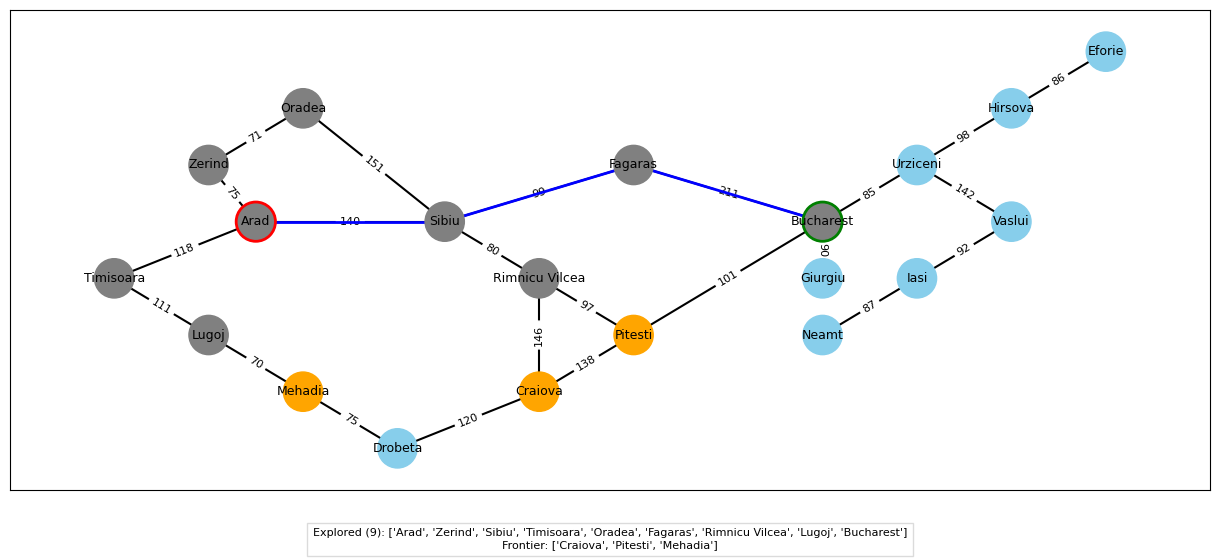

In [6]:
# Create a wider but shorter figure
fig, ax = plt.subplots(figsize=(15, 6))
path, explored, frontier = bfs(graph, start, end)
print(path)

visualize_graph(graph, pos, start, end, explored, frontier, path, ax=ax)

### Depth-First Search (DFS)

Depth-First Search (DFS) is a search algorithm that explores as far as possible along each branch before backtracking. Unlike BFS which expands all nodes at a given depth before going deeper, DFS dives deep into the search tree first before exploring alternative paths.

**Key characteristics:**
- Explores a path **all the way to its end** before backtracking
- Uses a **stack** (Last-In, First-Out) data structure for the frontier
- Memory-efficient because it only needs to store a single path from root to leaf

**How DFS works:**
1. Start at the root node and add it to the frontier (stack)
2. Remove the most recently added node from the stack
3. Mark the current node as explored
4. If this node is the goal, return the solution
5. Otherwise, add all of its unexplored neighbors to the stack
6. Repeat steps 2-5 until the goal is found or the stack is empty (no solution)

DFS can be implemented iteratively (using an explicit stack) or recursively (using the system's function call stack).

**Properties**

- **Completeness:** Yes (in finite spaces), No (in infinite spaces)
  - DFS will find a solution if one exists in a finite search space
  - In infinite spaces or those with infinite-depth paths, DFS may never return
- **Optimality:** No
  - DFS does not guarantee the optimal solution as it may find a very deep solution when a shallow one exists
- **Time Complexity:** $O(b^m)$
  - Where b is the branching factor and m is the maximum depth of the search space
- **Space Complexity:** $O(bm)$
  - Where b is the branching factor and m is the maximum depth
  - Much more space-efficient than BFS for deep trees


In [7]:
# DFS implementation
def dfs(graph, start, end):
    explored = []
    frontier = [start]  # Use a list as a stack
    parents = {start: None}
    
    while frontier:
        current_node = frontier.pop()  # LIFO (stack behavior)
        explored.append(current_node)   # Mark as explored immediately
        
        if current_node == end:
            # Reconstruct path
            path = []
            node = current_node
            while node is not None:
                path.append(node)
                node = parents[node]
            path.reverse()
            
            return path, explored.copy(), frontier.copy()
        
        # Process neighbors in reverse order to mimic recursive DFS behavior
        for neighbor in reversed(list(graph.neighbors(current_node))):
            if neighbor not in explored and neighbor not in frontier:
                parents[neighbor] = current_node
                frontier.append(neighbor)  # Add to the top of the stack

    return None, explored.copy(), frontier.copy()

def dfs_recursive(graph, start, end, explored=None, parents=None):
    # Initialize on first call
    if explored is None:
        explored = []
        parents = {start: None}
    
    explored.append(start)
    
    if start == end:
        # Reconstruct path
        path = []
        current = start
        while current is not None:
            path.append(current)
            current = parents[current]
        path.reverse()
        
        return path, explored.copy(), []
    
    # Process neighbors in natural order for recursive DFS
    for neighbor in graph.neighbors(start):
        if neighbor not in explored:
            parents[neighbor] = start
            result = dfs_recursive(graph, neighbor, end, explored, parents)
            if result is not None:
                return result
    
    return None

#### 🧑‍🏫 Demo: DFS for the Romania Map Problem

Let's use iterative DFS to find a path between Arad and Bucharest. The following codes shows how to use iterative DFS to get the final solution (a path from Arad to Bucharest). You'll see how the algorithm explores the graph step by step in the lecture demo.

You can try recursive DFS by calling the `dfs_recursive()` function.

['Arad', 'Sibiu', 'Fagaras', 'Bucharest']


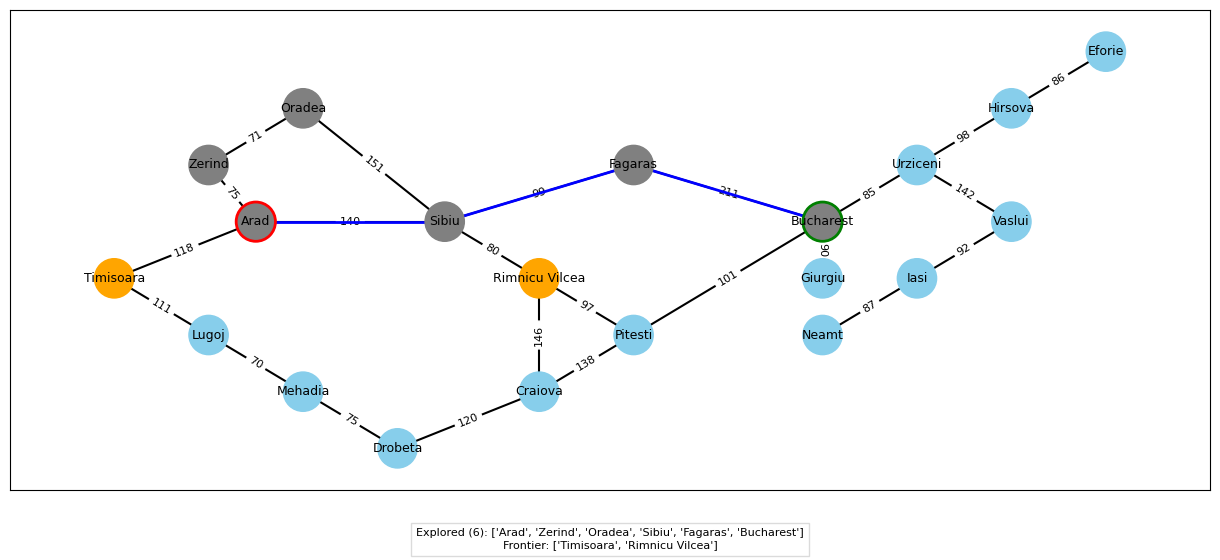

In [8]:
# Create a wider but shorter figure
fig, ax = plt.subplots(figsize=(15, 6))
path, explored, frontier = dfs(graph, start, end)
print(path)

visualize_graph(graph, pos, start, end, explored, frontier, path, ax=ax)

> 💬 **Discussion:** 
> 
> 🧠 Reflection: Since both BFS and DFS find the same path, did they explored the same number of nodes/cities to achieve the final solution? 
> 
> Can both of them guarantee the shortest path (in terms of steps)? 

### Uniform-Cost Search (UCS)

Uniform-Cost Search (UCS) is a modification of breadth-first search that prioritizes nodes based on path cost rather than depth. UCS always expands the node with the lowest **cumulative** path cost from the starting node.

**Key characteristics:**
- Explores nodes in **order of increasing path cost**
- Uses a **priority queue** data structure for the frontier, ordered by cumulative path cost
- Guarantees the optimal solution when all edge costs are positive

**How UCS works:**
1. Start at the root node and add it to the frontier with cost 0
2. Remove the lowest-cost node from the frontier
3. If this node is the goal, return the solution
4. Otherwise, add all unexplored neighbors to the frontier with their cumulative path costs
5. Mark the current node as explored
6. Repeat steps 2-5 until the goal is found or the frontier is empty (no solution)

UCS is essentially Dijkstra's algorithm for finding the shortest path in a graph with non-negative edge weights. It's particularly useful when different actions have different costs.


**Properties**

- **Completeness:** Yes (if all step costs > 0)
  - UCS will always find a solution if one exists, provided all edge costs are positive
- **Optimality:** Yes (if all step costs > 0)
  - UCS guarantees the optimal (lowest-cost) path to the goal
- **Time Complexity:** $O(b^{1+\lfloor C^*/\epsilon \rfloor})$
  - Where b is the branching factor, C* is the cost of the optimal solution, and ε is the minimum action cost
- **Space Complexity:** $O(b^{1+\lfloor C^*/\epsilon \rfloor})$
  - Like BFS, UCS must store all generated nodes in memory

> 🤖 **Practice with AI:** 
> 
> From BFS and DFS codes in the previous sections, you should have been familiar with the general implementation framework of a graph search algorithm (how to explore nodes the graph following different choices of frontier) (few-shot learning for human :-)). Now, please try to implement the UCS search algorithm with the help of your AI assistant(s). We'll walk through an implementation in the lecture.
>
> Suggestion: Be specific about the inputs/outputs. 
>
> 🧠 Critical Thinking: Does AI choose the correct data structure (heap) to save and organise the frontier nodes? Does the AI implementation work correctly (Has the shortest path been found?)?

In [ ]:
# TODO: Uniform-Cost Search (Dijkstra's algorithm)
def ucs(graph, start, end):
    # Your codes here

    return  # the path, explored nodes, and frontier for visualisation

You can use `visualize_graph()` to check whether the shortest path can be found.

In [ ]:
# Create a wider but shorter figure
fig, ax = plt.subplots(figsize=(15, 6))
path, explored, frontier = ucs(graph, start, end)
print(path)

visualize_graph(graph, pos, start, end, explored, frontier, path, ax=ax)

#### 🧑‍🏫 Demo: UCS for the Romania Map Problem

Let's use UCS to find a path between Arad and Bucharest. The following codes shows how to use UCS to get the optimal solution (the shortest path from Arad to Bucharest). You'll see how the algorithm explores the graph step by step in the lecture demo.

## Informed Search Algorithms
---


Informed search algorithms use domain-specific knowledge (heuristics) to guide the search process more efficiently.

### A* Search

A* is a popular informed search algorithm that combines the strengths of Uniform-Cost Search and greedy best-first search. It's designed to find the least-cost path from a start node to a goal node using a heuristic function to guide the search.

**Key characteristics:**
- Explores nodes based on a **combined cost function** $f(n) = g(n) + h(n)$
  - $g(n)$: the actual path cost from the start node to node $n$
  - $h(n)$: the estimated cost of the cheapest path from node $n$ to the goal
  - $f(n)$: estimated cost of the cheapest solution through $n$
- Uses a **priority queue** ordered by the `f_score`
- Balances between exploring optimal paths (like UCS) and moving toward the goal (using heuristics)

**How A\* works:**
1. Start at the initial node and assign f(start) = g(start) + h(start), where g(start) = 0
2. Add the start node to the frontier (priority queue)
3. While the frontier is not empty:
   - Remove the node with the lowest `f_score`
   - If this node is the goal, reconstruct and return the path
   - Otherwise, expand the node and update the cost to reach each neighbor
   - If a better path to a neighbor is found, update its costs and add/update it in the frontier

A* effectively combines the completeness and optimality of UCS with the efficiency of a heuristic-guided approach.


**想象你在陌生商场里找餐厅**
* 目标：从当前位置（3楼书店）找到 6 楼的火锅店

* 你手头有：商场地图（能看到楼梯、电梯位置），但不知道哪条路最快

**A*算法的决策过程**
1. 两个关键判断：

    已经花了多少时间（类似g(n)）：比如你已经走了 2 分钟到电梯口

    估计还要花多少时间（类似h(n)）：抬头看到指示牌显示餐厅在 6 楼，估计坐电梯要 1 分钟

    总和f(n)=2+1=3分钟：用这个总时间判断是否选这条路

2. 对比选项：

    选项A：走最近的楼梯（g=1分钟，但h=5分钟 → f=6）

    选项B：绕远坐直达电梯（g=3分钟，但h=1分钟 → f=4）

    A 会选择 B*：虽然绕远，但总预估时间更短

3. 动态调整：

    如果走到电梯口发现排队（实际 g 变长），会重新计算其他路径

#### Heuristics

The heuristic function $h(n)$ is the key component that makes A* more efficient than UCS. It guides the search toward promising paths by estimating the cost from the current node to the goal.

**Properties of good heuristics:**

1. **Admissibility**: A heuristic is admissible (optimistic) if it never overestimates the true cost to reach the goal.
   - $h(n)$ $\leq$ true cost from $n$ to goal. e.g., in the Romania map problem, a straight-line distance between two cities is admissible because the shortest path between any two points is a straight line.
   - Ensures that A* will find an optimal solution

2. **Consistency (or monotonicity)**: A heuristic is consistent if it satisfies the triangle inequality:
   - $h(n) \leq c(n,a,n') + h(n')$
   - Where $c(n,a,n')$ is the cost to move from $n$ to $n'$ via action a
   - Ensures that A* will never need to reopen explored nodes

**Common heuristics:**

1. **Euclidean distance (straight-line distance)**:
   - For spatial problems where movement can be in any direction
   - $h(n) = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$

2. **Manhattan distance**:
   - For grid-based problems where movement is only allowed in 4 directions (no diagonals)
   - $h(n) = |x_2-x_1| + |y_2-y_1|$

3. **Zero heuristic**: $h(n) = 0$
   - Makes A* equivalent to UCS

The choice of heuristic greatly affects A*'s efficiency. A more accurate heuristic (closer to the true cost without overestimating) leads to a more efficient search.

**Properties**

- **Completeness:** Yes (if branching factor is finite and h(n) > 0)
  - A* will always find a solution if one exists (with the constraints mentioned)
- **Optimality:** Yes (if h is admissible)
  - A* guarantees the optimal solution when using an admissible heuristic
- **Time Complexity:** $O(b^d)$ in worst case, but often much better with a good heuristic
  - Where b is the branching factor and d is the depth of the solution
  - A good heuristic can dramatically reduce the number of explored nodes
- **Space Complexity:** $O(b^d)$
  - Like BFS and UCS, A* must store all generated nodes in memory

#### 🧑‍🏫 Demo: A* for the Romania Map Problem

In [11]:
def demo_heuristic(node):
    """Return the predefined straight-line distance to Bucharest for demonstration purposes.(Based on Figure 3.22 AIMA 3rd Ed.)"""
    h_sld = {
        "Arad": 366,
        "Bucharest": 0,
        "Craiova": 160,
        "Drobeta": 242,
        "Eforie": 161,
        "Fagaras": 176,
        "Giurgiu": 77,
        "Hirsova": 151,
        "Iasi": 226,
        "Lugoj": 244,
        "Mehadia": 241,
        "Neamt": 234,
        "Oradea": 380,
        "Pitesti": 100,
        "Rimnicu Vilcea": 193,
        "Sibiu": 253,
        "Timisoara": 329,
        "Urziceni": 80,
        "Vaslui": 199,
        "Zerind": 374
    }

    return h_sld[node]

def heuristic(node, goal):
    return demo_heuristic(node)

In [12]:
# A* Search Algorithm
def astar(graph, start, end, heuristic_func):
    explored = []
    frontier = []
    # Priority queue with (f_score, node) where f_score = g_score + h_score
    # g_score is the cost from start to current node
    # h_score is the heuristic estimate from current node to goal
    heapq.heappush(frontier, (heuristic_func(start, end), 0, start))  # (f_score, g_score, node)
    
    parents = {start: None}
    g_scores = {start: 0}  # Cost from start to node
    
    while frontier:
        f_score, g_score, current_node = heapq.heappop(frontier)
        
        if current_node in explored:
            continue
            
        explored.append(current_node)
        
        if current_node == end:
            # Reconstruct path
            path = []
            node = current_node
            while node is not None:
                path.append(node)
                node = parents[node]
            path.reverse()
            
            frontier_nodes_with_scores = [(node, f) for (f, _, node) in frontier]
            
            # Fix: return proper frontier format with f_scores
            return path, explored, [(node, f) for (f, _, node) in frontier]
        
        # Explore neighbors
        for neighbor in graph.neighbors(current_node):
            # Calculate the cost to reach the neighbor
            edge_weight = graph[current_node][neighbor].get('weight', 1)
            tentative_g_score = g_scores[current_node] + edge_weight
            
            if neighbor not in g_scores or tentative_g_score < g_scores[neighbor]:
                # This path to neighbor is better than any previous one
                parents[neighbor] = current_node
                g_scores[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic_func(neighbor, end)
                heapq.heappush(frontier, (f_score, tentative_g_score, neighbor))
                
    # No path found
    return None, explored, [(node, f) for (f, _, node) in frontier]

['Arad', 'Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']


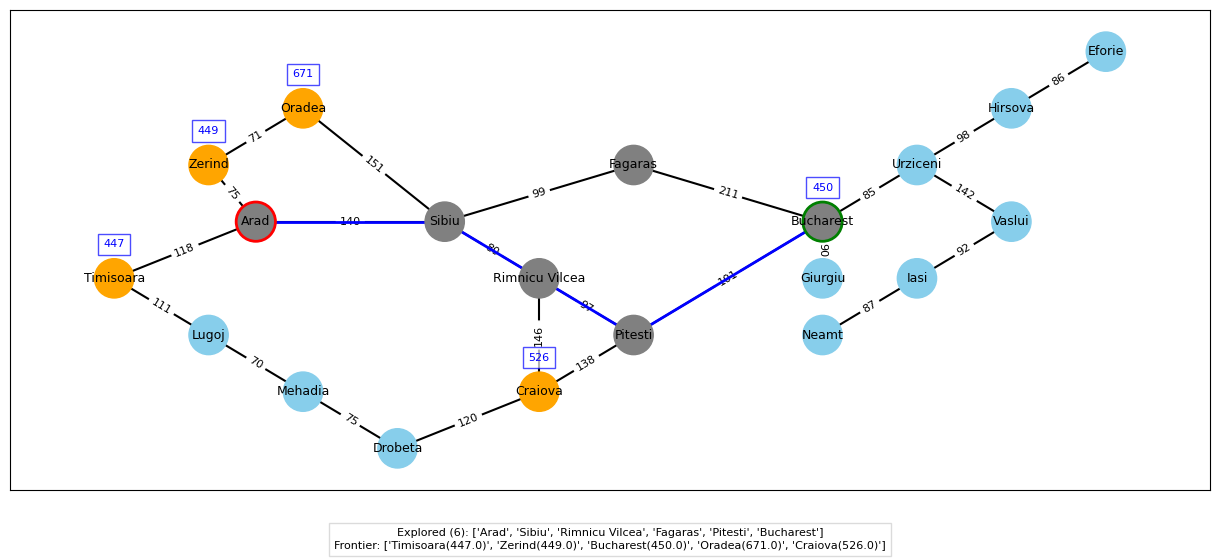

In [13]:
# Create a wider but shorter figure
fig, ax = plt.subplots(figsize=(15, 6))
path, explored, frontier = astar(graph, start, end, heuristic)
print(path)

visualize_astar(graph, pos, start, end, explored, frontier, path, ax=ax)

> 💬 **Discussion:** 
> 
> 🧠 Critical Thinking: The display of the `f_score` $f(n)$ for the final state has an issue. Can you find the issue based on the implementation of astar() function?

## Comparison of Search Algorithms
----

Let's compare the performance of different search algorithms on the same problem.

### Theoretical Comparison of Search Algorithms

| Property | BFS | DFS | UCS | A* |
|----------|-----|-----|-----|-----|
| **Completeness** | Yes (if branching factor is finite) | Yes (in finite spaces), No (in infinite spaces) | Yes (if step costs > 0) | Yes (with admissible heuristic) |
| **Optimality** | Yes (if steps have equal cost) | No | Yes (finds lowest-cost path) | Yes (with admissible heuristic) |
| **Time Complexity** | $O(b^d)$ - exponential in depth | $O(b^m)$ - m is max depth | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ - exponential in solution cost | $O(b^d)$ in worst case, but often better |
| **Space Complexity** | $O(b^d)$ - stores all nodes | $O(bm)$ - linear in depth | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ - stores all nodes | $O(b^d)$ - stores all nodes |
| **When to Use** | Finding shortest path (# of steps) in unweighted graphs | Path finding with limited memory; maze solving | Finding lowest-cost path when edge costs vary | Finding optimal paths efficiently using domain knowledge |

(*admissible huristic: never overestimate the true cost)

### Algorithm Selection Guide

When choosing a search algorithm, consider:

#### BFS: Use when
- All actions have the same cost
- The goal is close to the start
- You need the shortest path (fewest steps)
- Memory is not a constraint

#### DFS: Use when
- Memory is limited
- You suspect solutions are deep in the tree
- There are multiple solutions and finding any one is sufficient
- The search space is very large but solutions are frequent

#### UCS: Use when
- Actions have different costs
- You need the optimal (lowest-cost) path
- Heuristic information is not available
- Memory is not a constraint

#### A*: Use when
- Actions have different costs
- You need the optimal path
- A good heuristic is available
- Efficiency is important

#### Trade-offs:
- Memory usage: DFS < A* ≤ UCS ≤ BFS
- Optimality guarantee: DFS < BFS < UCS = A* (with admissible heuristic)
- Speed for informed problems: BFS < DFS < UCS < A* (with good heuristic)

## State Representation for Search Problems
---

Search algorithms can be applied beyond simple route finding problems to a wide variety of challenges by representing them as searches through abstract state spaces. The formulation of a problem as a state space search allows us to apply the same search algorithms (BFS, DFS, UCS, A*) to diverse problems ranging from simple puzzles to complex planning tasks.

**From Route Finding to State Space Search 路径查找到状态空间搜索**

- **Route finding** involves searching for paths in physical space represented as graphs
- **State space search** generalizes this concept to abstract state representations
- A **state** represents a complete configuration of the environment/problem
- The goal is to find a sequence of actions that transform the initial state to a goal state

**Key Characteristics of State Space Representation 状态空间表征的核心要素**

- **States**: Complete snapshots of the world/problem at a given moment
- **Actions**: Operators that transform one state into another
- **Transition model**: Defines how actions change states
- **Goal test**: Function determining if a state satisfies the solution criteria
- **Path**: A sequence of states connected by actions

### Examples

#### Vacuum World Problem

<img src="imgs/L02_StateRep_VacuumWorld.png" alt="Vacuum World" style="width:80%; height:auto;">

Image Source: Figure 3.3 AIMA 3rd Ed.

- **States**: Location of vacuum (left/right) and dirt status of each square (clean/dirty) $2 \times 2^2 = 8$ possible states.
- **Actions**: Left, Right, Suck.
- **Transition model**:  The actions have their expected effects, except that moving Left in the leftmost square, moving Right in the rightmost square, and Sucking in a clean square have no effect.
- **Goal test**: All squares are clean.
- **Path cost**: Each step costs 1, so the path cost is the number of steps in the path.

#### Sliding Puzzle Problem (8-puzzle)

<img src="imgs/L02_StateRep_8Puzzle.png" alt="8-Puzzle" style="width:80%; height:auto;">

Image Source: Figure 3.10 AIMA 3rd Ed.

- **States**: Arrangements of tiles in the puzzle grid
- **Actions**: Moving the blank space up, down, left, or right. Different subsets of these are possible depending on where the blank is.
- **Transition model**: Given a state and action, this returns the resulting state.
- **Goal test**: This checks whether the state matches an specific arrangement of tiles (usually ordered)
- **Path cost**: Each step costs 1, so the path cost is the number of steps in the path.

## Bonus Scene
---

### Beam Search

Beam Search is a heuristic search algorithm that combines elements of breadth-first search with a greedy approach. It addresses the memory limitations of both BFS and A* by keeping only a fixed number of promising candidates at each step.

**Key characteristics:**
- Uses a **beam width** parameter ($w$) to limit the frontier size
- Explores nodes level by level, like BFS
- At each level, keeps only the $w$ most promising nodes (based on heuristic evaluation)
- Trades off completeness for efficiency

**How Beam Search works:**
1. Start with the initial node in the frontier
2. Generate all successors of nodes in the frontier
3. Sort all these successors by their heuristic values
4. Keep only the $w$ best successors as the new frontier
5. If a goal node is in the frontier, return success
6. Otherwise, continue with step 2

Beam Search can be seen as a compromise between greedy best-first search ($w=1$) and breadth-first search ($w=\infty$).

**Properties**

- **Completeness:** No
  - Beam Search may discard paths leading to solutions if they don't appear promising early on
- **Optimality:** No
  - Even with an admissible heuristic, optimal paths might be pruned
- **Time Complexity:** $O(bw)$
  - Where $b$ is the branching factor and $w$ is the beam width
- **Space Complexity:** $O(w)$
  - Significantly better than BFS or A* for large problems

**When to use Beam Search:**
- Problems with large search spaces where memory is a constraint
- When finding a good (but not necessarily optimal) solution quickly is preferable
- Applications like speech recognition, machine translation, and image captioning

#### 🧑‍🏫 Example: Beam Search for Text Generation

Let's use an example based GenAI to show how the beam search works to complete the following sentence:

*Beam search algorithms are useful because* ...

![Beam Search for GenAI](./imgs/L02_BeamSearch_TokenGen.png)

现在不用beam search了，主要都用sampling: temperature, top_p, top_k...

## Conclusion
---

In this lesson, we've explored several fundamental search algorithms for problem solving. We've covered:

- **Uninformed search strategies** (BFS, DFS, UCS) that operate without domain-specific knowledge
- **Informed search strategies** (A*, Beam Search) that leverage heuristics to guide the search process more efficiently
- **Practical implementations** of these algorithms applied to the Romania Map problem

These search algorithms demonstrate a key concept in AI: the ability to systematically explore a problem space to find solutions. Through our exploration of different algorithms, we've seen how:

1. **BFS** guarantees the shortest path in terms of steps but can be memory-intensive
2. **DFS** uses minimal memory but may find suboptimal paths and potentially get stuck in infinite paths
3. **UCS** finds the lowest-cost path but expands more nodes than necessary
4. **A\*** combines the optimality of UCS with the efficiency of heuristic guidance
5. **Beam Search** trades off optimality for efficiency in large problem spaces

Search algorithms remain essential in modern AI applications including:
- Pathfinding in games and robotics
- Planning systems for logistics and scheduling
- Natural language processing (like Beam Search in text generation)
- Enhance reasoning capablities of LLMs in test time compute (Next Lesson).

